# Final Project

Goals
* Box + vanishing point -> 3D image
* Manual detection of box?
```
───────────────────────────────────────
───▐▀▄───────▄▀▌───▄▄▄▄▄▄▄─────────────
───▌▒▒▀▄▄▄▄▄▀▒▒▐▄▀▀▒██▒██▒▀▀▄──────────
──▐▒▒▒▒▀▒▀▒▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▀▄────────
──▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▄▒▒▒▒▒▒▒▒▒▒▒▒▀▄──────
▀█▒▒▒█▌▒▒█▒▒▐█▒▒▒▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌─────
▀▌▒▒▒▒▒▒▀▒▀▒▒▒▒▒▒▀▀▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐───▄▄
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌▄█▒█
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒█▒█▀─
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒█▀───
▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌────
─▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐─────
─▐▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▌─────
──▌▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▐──────
──▐▄▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▄▌──────
────▀▄▄▀▀▀▀▀▄▄▀▀▀▀▀▀▀▄▄▀▀▀▀▀▄▄▀────────
```

## Setup

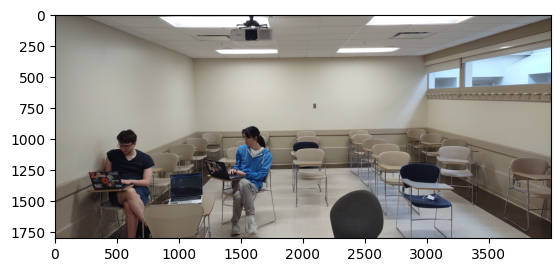

In [148]:
import numpy as np
import numpy.linalg as la
import cv2
import matplotlib.pyplot as plt
import numpy.linalg as linalg

import utils

image = cv2.imread("./pictures/trial_room.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter

plt.imshow(image_rgb)
plt.show()

### Back wall + vanishing point 

In [185]:
# box coordinates

box = np.array( # Trial Room
    [[(1113,  356), (2987,  356)],
     [(1113, 1224), (2987, 1224)] ]
)

# vanishing point the image is a bit offcenter
vp = np.array((1906, 643))


width_box  = np.average(box[:,1,0] - box[:,0,0])
height_box = np.average(box[1,:,1] - box[0,:,1])

height_image = len(image_rgb)
width_image = len(image_rgb[0])

### Depth

In [204]:
# Computing Depth

fstop = 1.7
focal_length_mm = 5 # TODO use package to auto import from iamges
aperture_diameter_mm = focal_length_mm / fstop

# bottom = np.average([box[1,0], box[1,1]])
# # dv = vp[1] - bottom

# # compute dimensions of box
# # f / (va - v0) = d / H
# depth = focal_length_mm * height_box / (aperture_diameter_mm / 2)
# print(depth) 

half_aperature = aperture_diameter_mm / 2

# Compute half of the image
half_image = height_image /2

# Compute half of the backwall
half_back_wall = height_box / 2

# Solve for the va - v0 value 
va_minus_vo = half_aperature * half_back_wall / half_image




# Use similar Triangles to compute the Depth

height_vanishing = box[1][1][1] - vp[1]
print(height_vanishing)

depth_image = focal_length_mm * height_vanishing / (va_minus_vo)
depth_image = int(depth_image)

581


### Homography

#### Box for each wall

In [202]:
# compute points for floor
# extend line
alpha = 2 # TODO calculate depth of close_box from alpha
close_box = vp * (1 - alpha) + box * alpha

# length
box_lengths = la.norm(close_box - box, axis=-1)

# this will take all the box coordinates and stretch them out
# which basically draws a wall parallel to the back wall that is closer to you
print(box)
print(close_box)
print(box_lengths)

left_box = np.stack([close_box[:,0], box[:,0]], axis=1)
right_box = np.stack([box[:,1], close_box[:, 1]], axis=1)
top_box = np.stack([close_box[0,:], box[0,:]], axis=0)
bottom_box = np.stack([box[1,:], close_box[1,:]], axis=0)


# fov = 2 * np.arctan(depth/(2 * focal_length_mm)) # angle
# compute visible depth, i.e. depth of the edge where the wall meets the floor (or where the wall meets the ceiling)
tan_fov = (aperture_diameter_mm/2) / focal_length_mm

camera_height = vp[0] - box
hidden_depth = 1/tan_fov * camera_height
visible_depth = depth_image - hidden_depth

camera_distances_to_edge = la.norm(box - vp, axis = -1) # == vp distance to corner
hidden_depths = 1/tan_fov * camera_distances_to_edge
visible_depths = depth_image - hidden_depths

[[[1113  356]
  [2987  356]]

 [[1113 1224]
  [2987 1224]]]
[[[ 320   69]
  [4068   69]]

 [[ 320 1805]
  [4068 1805]]]
[[ 843.33741764 1118.44982006]
 [ 983.06154436 1227.2416225 ]]


In [201]:
print(visible_depths)

[[1229.10439291  293.72222469]
 [ 754.04236208  -76.1699036 ]]


In [207]:
def computeHomography(top, bottom, height, depth):
    '''
    Compute homography for wall/floor/ceiling.
    
    - top: 2 points
    - bottom: 2 points
    - height: height
    - depth: depth / length of the box face
    '''
    # TO DO
    # create A
    A = np.zeros((8, 9))
    
    # TOP LEFT
    u = top[0,0]
    v = top[0,1]

    u_prime = 0
    v_prime = 0
    A[0] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[1] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)


    # TOP RIGHT

    u = top[1,0]
    v = top[1,1]

    u_prime = depth
    v_prime = 0
    A[2] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[3] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)

    # BOTTOM LEFT

    u = bottom[0,0]
    v = bottom[0,1]

    u_prime = 0
    v_prime = height
    A[4] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[5] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)


    # BOTTOM RIGHT

    u = bottom[1,0]
    v = bottom[1,1]
 
    u_prime = depth
    v_prime = height
    A[6] = (-u,-v,-1, 0,0,0, u * u_prime, v * u_prime, u_prime)
    A[7] = (0,0,0, -u, -v, - 1, u * v_prime, v * v_prime, v_prime)



    U, S, V= linalg.svd(A)

    V_T = V[-1].T
    H = V_T.reshape(3,3)

    return H

## Project each side of box (wall/ceiling/floor)

### Left wall

[[ 3.11915255e-03 -1.42768826e-13 -9.98128815e-01]
 [-4.71854852e-04  1.30376619e-03  6.10336853e-02]
 [-7.61511852e-07  1.03134732e-16  1.45144159e-03]]


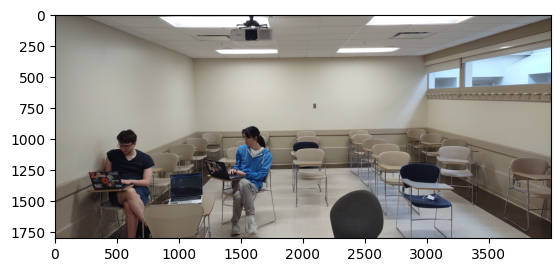

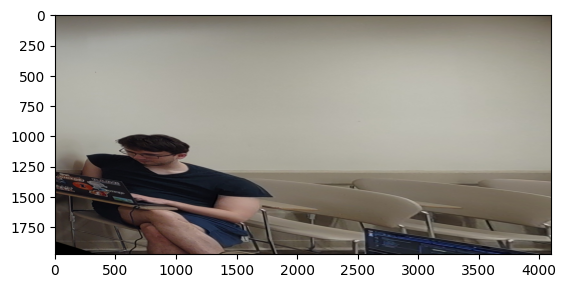

In [ ]:
# Compute Left

width = int(width_box)

H = computeHomography(left_box[0], left_box[1], width, depth_image)
print(H)

plt.figure()
plt.imshow(image_rgb)

projectedWidth = depth_image # 2 * width + 100
projectedHeight = width + 100
Tr = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]]).astype('float32') # Translation

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()

plt.imshow(projIm1)

### Top (ceiling)

[[-4.33541216e-03  1.19790308e-02  5.60778765e-01]
 [ 1.03571665e-14 -1.19966496e-02  8.27768820e-01]
 [-2.77555756e-17  6.91051242e-06 -4.44345949e-03]]


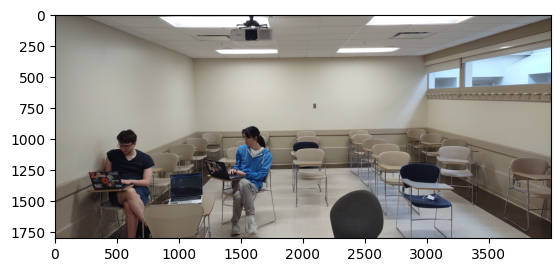

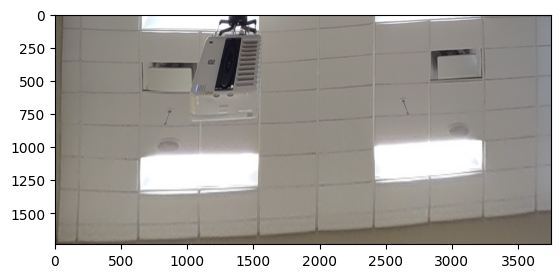

In [194]:
# Compute TOP

width = int(2 * width_box)
height = int(2 * height_box)

H = computeHomography(top_box[0], top_box[1], height, depth_image)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = width
projectedHeight = height
Tr = np.array([[1, 0, 10], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)

### Right wall

[[-3.25573893e-04  3.46497648e-13  9.72489218e-01]
 [-5.38247162e-05 -2.02733513e-04  2.32947558e-01]
 [-4.34330166e-08  8.65921782e-17  8.27833294e-05]]


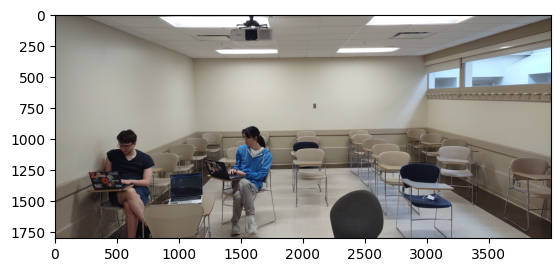

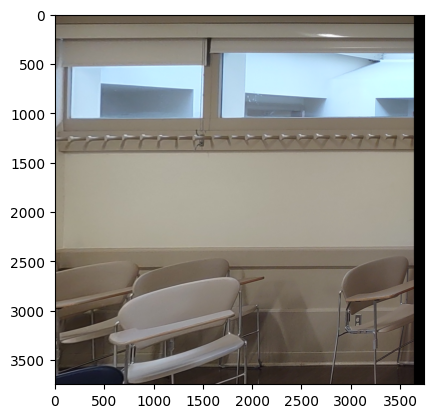

In [206]:
# Compute RIGHT

width = int(2 * width_box)
height = int(2 * height_box)

H = computeHomography(right_box[0], right_box[1], width, width)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = width
projectedHeight = width
Tr = np.array([[1, 0, 10], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)

### Bottom (floor)

[[-2.17576111e-04 -2.96967051e-04  6.05649882e-01]
 [ 4.98169214e-15 -6.50106935e-04  7.95730889e-01]
 [ 8.32125167e-18 -1.87242781e-07  1.20397108e-04]]


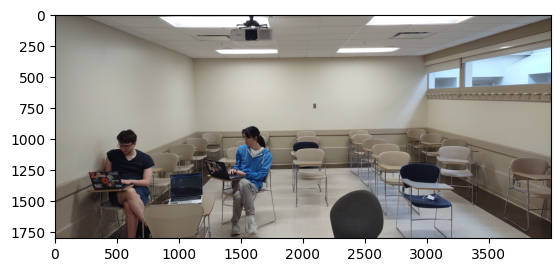

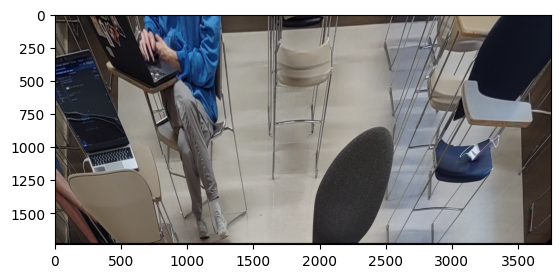

In [156]:
# Compute Left

width = int(2 * width_box)
height = int(2 * height_box)

H = computeHomography(bottom_box[0], bottom_box[1], height, width)
print(H)

plt.figure()
plt.imshow(image_rgb)


projectedWidth = width
projectedHeight = height
Tr = np.array([[1, 0, 10], [0, 1, 0], [0, 0, 1]]).astype('float32')

# TO DO: warp and blend the two images
# images location
# Load an color image in grayscale
projIm1 = cv2.warpPerspective(image_rgb, 
							  Tr@H, 
							  (projectedWidth, 
		  					   projectedHeight))
plt.figure()
plt.imshow(projIm1)